In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, classification_report

In [2]:
data = pd.read_csv('data/diabetes_binary_classification_data.csv')
print(data.head())

   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0   

In [3]:
# Basic information about the dataset
print(data.describe())
print(data.info())

# Check for missing values
print(data.isnull().sum())

       Diabetes_binary         HighBP       HighChol      CholCheck  \
count    253680.000000  253680.000000  253680.000000  253680.000000   
mean          0.139333       0.429001       0.424121       0.962670   
std           0.346294       0.494934       0.494210       0.189571   
min           0.000000       0.000000       0.000000       0.000000   
25%           0.000000       0.000000       0.000000       1.000000   
50%           0.000000       0.000000       0.000000       1.000000   
75%           0.000000       1.000000       1.000000       1.000000   
max           1.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000      

The information about the dataset says that Diabetes_binary with a value of 2 means that the person has diabetes, but no rows have a value of 2. We will therefore assume that Diabetes_binary with a value of 1 means that the person has diabetes and 0 means that the person does not have diabetes.

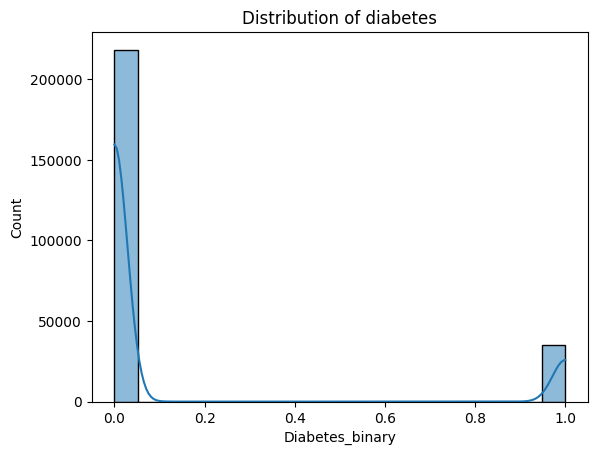

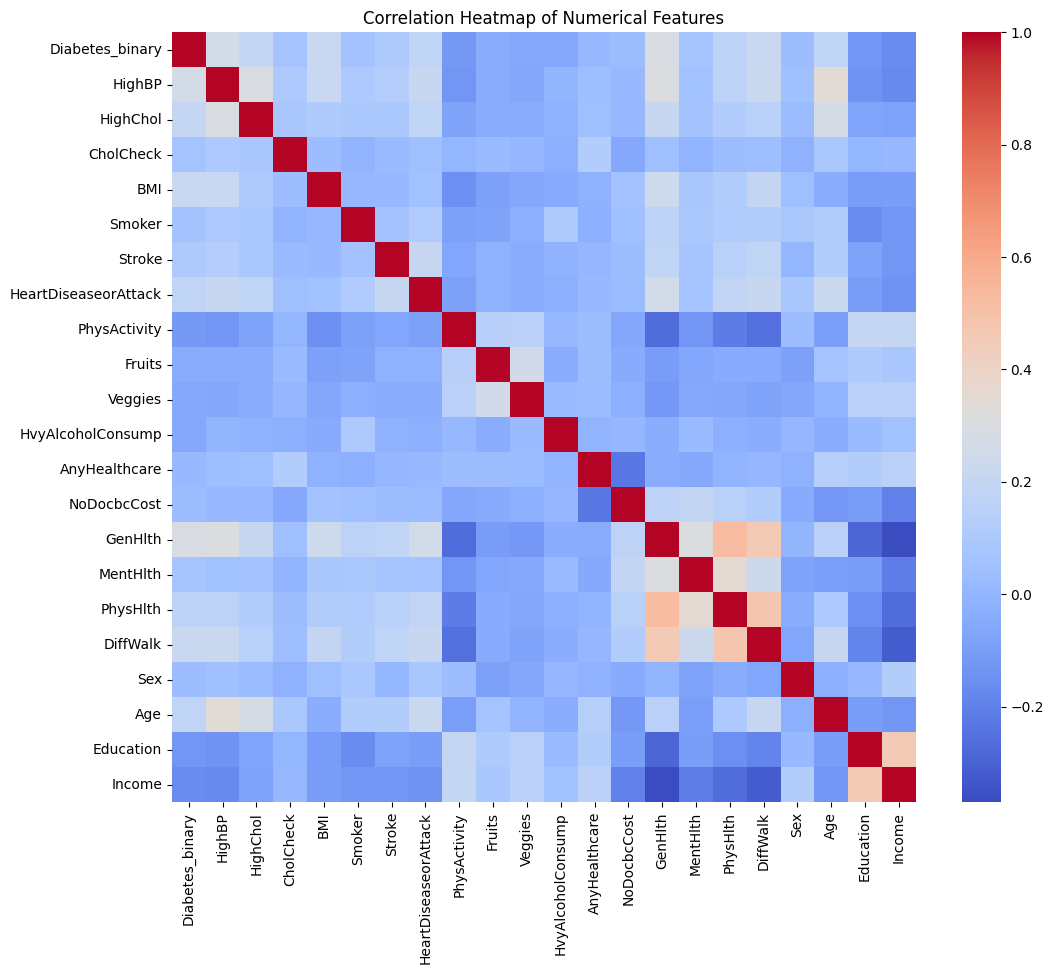

In [4]:
sns.histplot(data['Diabetes_binary'], kde=True)
plt.title('Distribution of diabetes')
plt.show()

# Correlation heatmap for numerical features
corr_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Discussion around diagrams above
From the first diagram above we can see that the dataset contains way more negative results than positive that could comprimise our model.
We can also see that no signle feature has a very strong correlation.

In [5]:
# Filling missing values with the median for numerical columns and mode for categorical columns
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].median())

# Convert categorical variables using one-hot encoding
data = pd.get_dummies(data)

In [6]:
# Finding highly correlated features
high_corr_features = corr_matrix['Diabetes_binary'].sort_values(ascending=False)
strong_corr_features = high_corr_features[abs(high_corr_features) > 0.2].index.tolist()
print("Strongly correlated features:", strong_corr_features)
extra_strong_corr_features = high_corr_features[abs(high_corr_features) > 0.25].index.tolist()
print("Extra strongly correlated features:", extra_strong_corr_features)

Strongly correlated features: ['Diabetes_binary', 'GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol']
Extra strongly correlated features: ['Diabetes_binary', 'GenHlth', 'HighBP']


In [7]:
# Finding the most important features using GradientBoostingRegressor
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = GradientBoostingRegressor()
gbr.fit(X_train_scaled, y_train)
feature_importances = gbr.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
print(feature_importances_df)


                 feature  importance
13               GenHlth    0.292692
0                 HighBP    0.256439
3                    BMI    0.177854
18                   Age    0.076900
1               HighChol    0.074016
16              DiffWalk    0.050574
6   HeartDiseaseorAttack    0.034753
20                Income    0.009352
10     HvyAlcoholConsump    0.007940
17                   Sex    0.005321
2              CholCheck    0.003963
5                 Stroke    0.003427
19             Education    0.002058
14              MentHlth    0.001651
15              PhysHlth    0.001460
8                 Fruits    0.000396
4                 Smoker    0.000316
11         AnyHealthcare    0.000313
12           NoDocbcCost    0.000225
7           PhysActivity    0.000208
9                Veggies    0.000140


### Important features
We found the most important features by looking at the correlation and by using the feature_importances_ on GradientBoostingRegressor.
What we found is that GenHlth and HighBP is the most important and that BMI, Age, HighChol and DiffWalk are also important to a lesser degree.

We chose to run our 3 selected models with our top 3 most important features, top 6 most important features and all features to see how our results would change.

In [10]:
# Top 3 important features
top_3_features = feature_importances_df['feature'].head(3).tolist()
X_train_top_3 = X_train[top_3_features]
X_test_top_3 = X_test[top_3_features]

# Top 6 important features
top_6_features = feature_importances_df['feature'].head(6).tolist()
X_train_top_6 = X_train[top_6_features]
X_test_top_6 = X_test[top_6_features]

# The 3 selected models
models = {
  'GradientBoostingRegressor': GradientBoostingRegressor(),
  'LinearRegression': LinearRegression(),
  'RandomForestRegressor': RandomForestRegressor()
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
  results = {}
  for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
  return results

# Evaluate models with top 3 features
results_top_3 = train_and_evaluate(models, X_train_top_3, X_test_top_3, y_train, y_test)
print("Results with top 3 features:")
for model, result in results_top_3.items():
  print(model, result)

# Evaluate models with top 6 features
results_top_6 = train_and_evaluate(models, X_train_top_6, X_test_top_6, y_train, y_test)
print("Results with top 6 features:")
for model, result in results_top_6.items():
  print(model, result)

# Evaluate models with all features
results_all = train_and_evaluate(models, X_train, X_test, y_train, y_test)
print("Results with all features:")
for model, result in results_all.items():
  print(model, result)

Results with top 3 features:
GradientBoostingRegressor {'MAE': np.float64(0.20299494924513126), 'MSE': np.float64(0.3169325324407882), 'R2': 0.1551387963382056}
LinearRegression {'MAE': np.float64(0.21821384729774906), 'MSE': np.float64(0.32041334317161824), 'R2': 0.1364789821507867}
RandomForestRegressor {'MAE': np.float64(0.20264730725293378), 'MSE': np.float64(0.31747836448471406), 'R2': 0.15222619269844428}
Results with top 6 features:
GradientBoostingRegressor {'MAE': np.float64(0.19693874261079647), 'MSE': np.float64(0.3109710473091204), 'R2': 0.1866234666522799}
LinearRegression {'MAE': np.float64(0.21751126581223743), 'MSE': np.float64(0.31687745613964086), 'R2': 0.15543240953460913}
RandomForestRegressor {'MAE': np.float64(0.19571176896191408), 'MSE': np.float64(0.32316902007657106), 'R2': 0.12156189055311672}
Results with all features:
GradientBoostingRegressor {'MAE': np.float64(0.19740216536370414), 'MSE': np.float64(0.3095182894836919), 'R2': 0.19420538794665665}
LinearReg

### Evalutating models
All models seems to get relatively low error values for MAE and MSE of around 0.2 and 0.3 respectively. This often means that good at predicting the target variable, but we can see that all the models also gets a low R2 score.
It therefore seems like the models are not good at predicting wheather a person has diabetes.

In [11]:
# Function to train and evaluate models with confusion matrix and classification report
def evaluate_models(models, X_train, X_test, y_train, y_test):
  for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Convert continuous predictions to binary
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_binary)
    print(f"Confusion Matrix for {name}:\n{cm}\n")
    
    cr = classification_report(y_test, y_pred_binary)
    print(f"Classification Report for {name}:\n{cr}\n")

# Evaluate models with top 3 features
print("Evaluation with top 3 features:")
evaluate_models(models, X_train_top_3, X_test_top_3, y_train, y_test)

# Evaluate models with top 6 features
print("Evaluation with top 6 features:")
evaluate_models(models, X_train_top_6, X_test_top_6, y_train, y_test)

Evaluation with top 3 features:
Confusion Matrix for GradientBoostingRegressor:
[[43198   541]
 [ 6340   657]]

Classification Report for GradientBoostingRegressor:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     43739
         1.0       0.55      0.09      0.16      6997

    accuracy                           0.86     50736
   macro avg       0.71      0.54      0.54     50736
weighted avg       0.83      0.86      0.82     50736


Confusion Matrix for LinearRegression:
[[43655    84]
 [ 6921    76]]

Classification Report for LinearRegression:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93     43739
         1.0       0.47      0.01      0.02      6997

    accuracy                           0.86     50736
   macro avg       0.67      0.50      0.47     50736
weighted avg       0.81      0.86      0.80     50736


Confusion Matrix for RandomForestRegressor:
[[43104   635]
 [ 62

### Conclusions about classifications and confusion matrices
If we look at the confusion matrices of the different models we can see that they have a high percentage of True negatives compared to false negatives. At the same time all the models fail to give more true positives than false positives with most models landing at around 50/50.
We therefore conclude that it is not possible to predict to a higher degree wheather someone has diabetes. The data can highlight what makes it more likely to get diabetes and also can detect true negatives quite good.